# Normalizing Flows

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools

In [3]:
import flows

In [4]:
import jax
import jax.numpy as jnp
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers

In [5]:
from sklearn import datasets, preprocessing

In [6]:
from tomo_challenge import load_data

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [7]:
from zotbin.group import plotfbins

In [8]:
bands='riz'
include_colors=False
include_errors=False

In [9]:
train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
#train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Use r-i, z-i, i as the features:

In [11]:
n_samples= 100000
X = np.concatenate((np.diff(train_data[:n_samples], axis=1), train_data[:n_samples, 1:2]), axis=1)

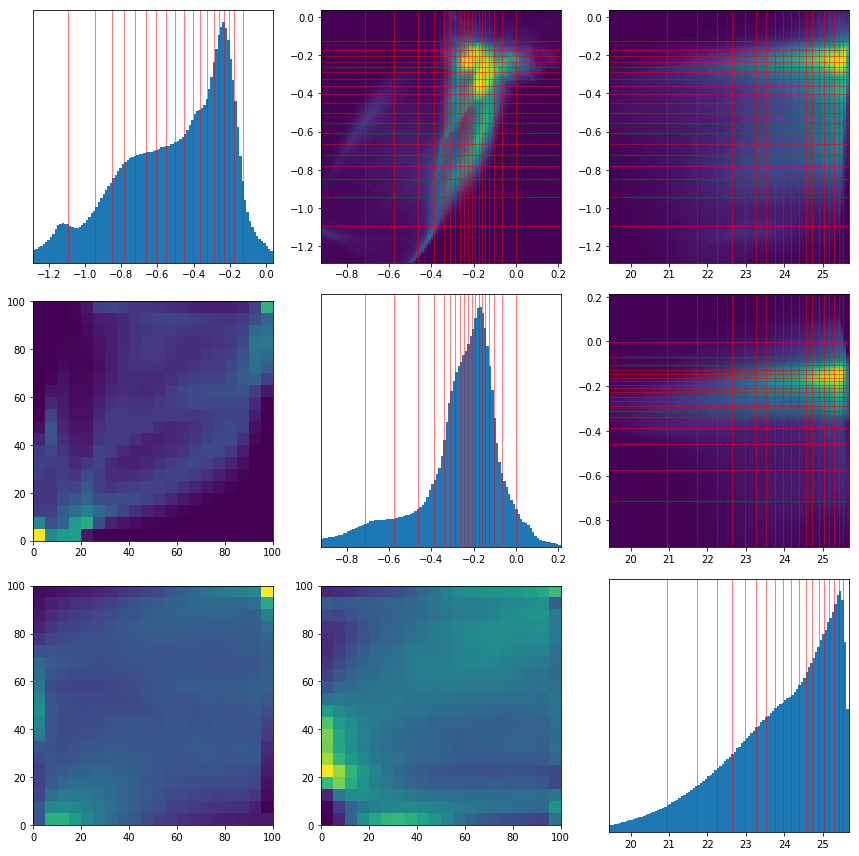

In [11]:
plotfbins(X)

In [12]:
if False:
    n_samples = 10000
    plot_range = [(-2, 2), (-2, 2)]
    n_bins = 100

    scaler = preprocessing.StandardScaler()
    X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
    X = scaler.fit_transform(X)
    plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, range=plot_range)[-1];

In [12]:
rng, flow_rng = jax.random.split(jax.random.PRNGKey(0))
input_dim = X.shape[1]
num_epochs, batch_size = 200, 2000

In [13]:
def get_masks(input_dim, hidden_dim, num_hidden):
    masks = []
    input_degrees = jnp.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [jnp.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]
    print('degrees:', [d.shape for d in degrees])

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [jnp.transpose(jnp.expand_dims(d1, -1) >= jnp.expand_dims(d0, 0)).astype(jnp.float32)]
    print('masks:', [m.shape for m in masks])
    return masks

hidden_dim = 128
num_hidden = 1
nunit = 5

def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=hidden_dim, num_hidden=num_hidden)
    act = stax.Relu
    init_fun, apply_fun = stax.serial(
        flows.MaskedDense(masks[0]),
        act,
        flows.MaskedDense(masks[1]),
        act,
        flows.MaskedDense(masks[2].tile(2)),
    )
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun

# Initialize our flow bijection.
bijection_init_fun = flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * nunit)

# Create direct and inverse bijection functions.
bijection_rng, rng = jax.random.split(rng)
bijection_params, bijection_direct, bijection_inverse = bijection_init_fun(bijection_rng, input_dim)

# Initialize our flow model.
prior_init_fun = flows.Normal()
#prior_init_fun = Uniform()
flow_init_fun = flows.Flow(bijection_init_fun, prior_init_fun)
initial_params, log_pdf, sample = flow_init_fun(flow_rng, input_dim)

degrees: [(3,), (128,), (128,), (3,)]
masks: [(3, 128), (128, 128), (128, 3)]
degrees: [(3,), (128,), (128,), (3,)]
masks: [(3, 128), (128, 128), (128, 3)]
degrees: [(3,), (128,), (128,), (3,)]
masks: [(3, 128), (128, 128), (128, 3)]
degrees: [(3,), (128,), (128,), (3,)]
masks: [(3, 128), (128, 128), (128, 3)]
degrees: [(3,), (128,), (128,), (3,)]
masks: [(3, 128), (128, 128), (128, 3)]
degrees: [(3,), (128,), (128,), (3,)]
masks: [(3, 128), (128, 128), (128, 3)]
degrees: [(3,), (128,), (128,), (3,)]
masks: [(3, 128), (128, 128), (128, 3)]
degrees: [(3,), (128,), (128,), (3,)]
masks: [(3, 128), (128, 128), (128, 3)]
degrees: [(3,), (128,), (128,), (3,)]
masks: [(3, 128), (128, 128), (128, 3)]
degrees: [(3,), (128,), (128,), (3,)]
masks: [(3, 128), (128, 128), (128, 3)]


In [14]:
def loss(params, inputs):
    return -log_pdf(params, inputs).mean()

@jax.jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    gradients = jax.grad(loss)(params, inputs)
    return opt_update(i, gradients, opt_state)

In [15]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

In [16]:
import jax.scipy.special

epoch 1


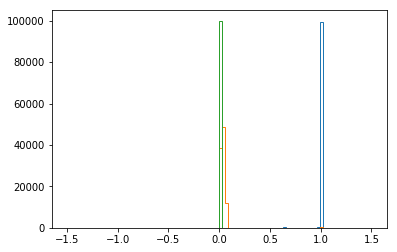

epoch 11


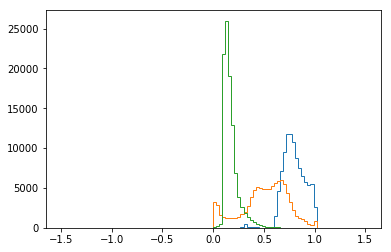

epoch 21


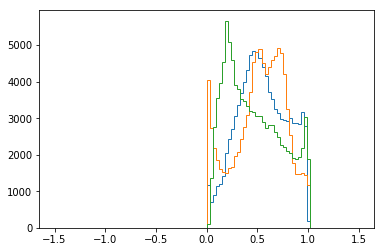

epoch 31


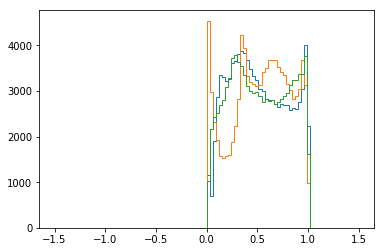

epoch 41


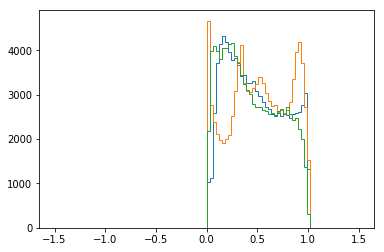

epoch 51


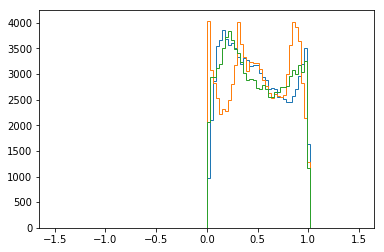

epoch 61


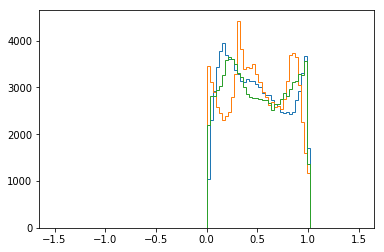

epoch 71


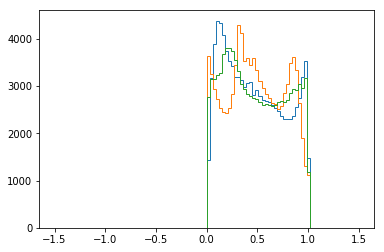

epoch 81


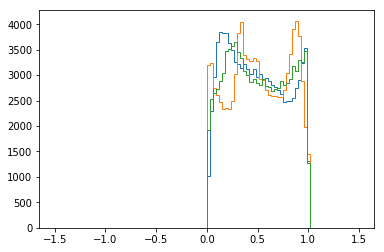

epoch 91


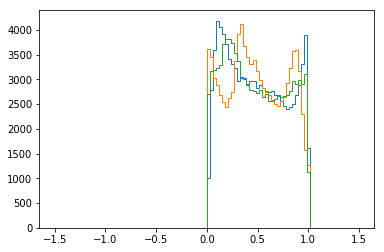

epoch 101


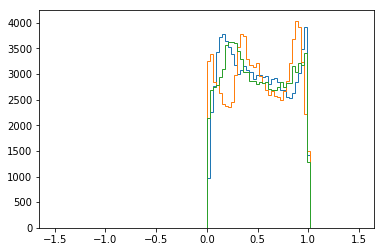

epoch 111


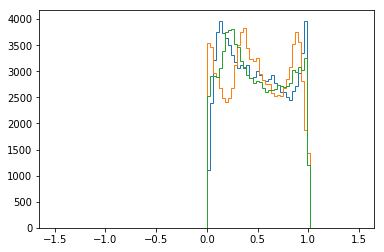

epoch 121


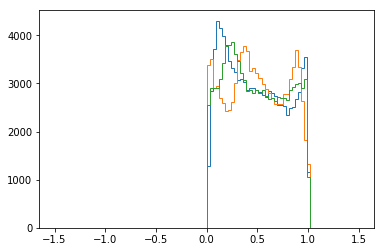

epoch 131


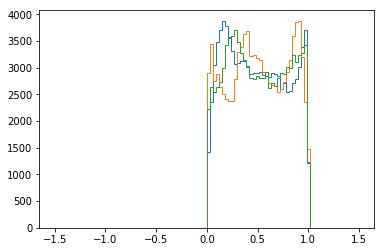

epoch 141


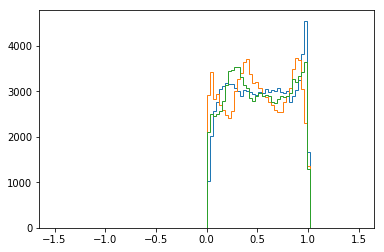

epoch 151


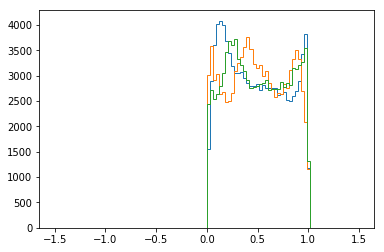

epoch 161


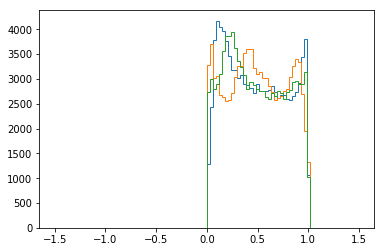

epoch 171


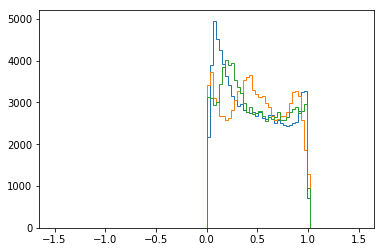

epoch 181


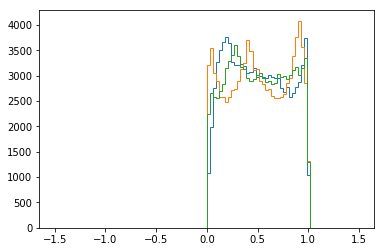

epoch 191


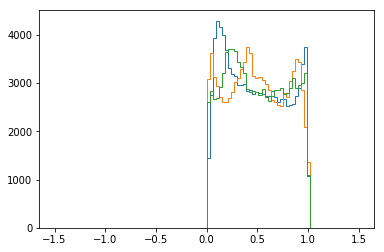

epoch 200


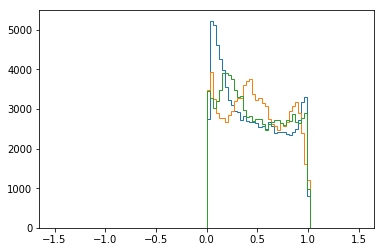

In [17]:
nsample = X.shape[0]
X_trace_in = X.copy()
#bins = np.linspace(-3, 3, 101)
bins = np.linspace(-1.5, 1.5, 101)

opt_state = opt_init(initial_params)
itercount = itertools.count()

for epoch in range(num_epochs):

    permute_rng, rng = jax.random.split(rng)
    X = jax.random.permutation(permute_rng, X)
    for batch_index in range(0, len(X), batch_size):
        opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
    
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print('epoch', epoch + 1)
        epoch_params = get_params(opt_state)
        
        # Map the input data back through the flow to the prior space.
        X_trace_out, log_det_jac_inv = bijection_direct(epoch_params, X_trace_in)
        U = 0.5 * (1 + jax.scipy.special.erf(X_trace_out / jnp.sqrt(2)))
        for i in range(input_dim):
            plt.hist(U[:, i], bins, histtype='step')
        plt.show()
        '''
        # Draw random samples from the prior and pass them through the flow.
        sample_rng, rng = jax.random.split(rng)
        X_syn = sample(rng, epoch_params, nsample)
        # Plot.
        plt.hist2d(X_syn[:, 0], X_syn[:, 1], bins=n_bins, range=plot_range)
        plt.show()
        '''

In [104]:
import scipy.special

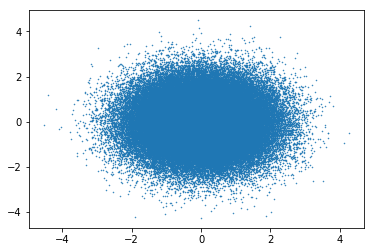

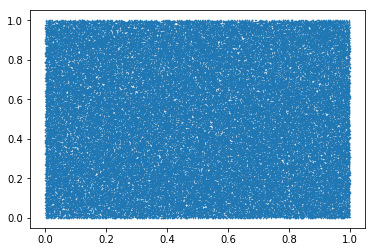

In [118]:
def test_flatten(n=100000, dim=3):
    x = np.random.normal(size=(n, dim))
    plt.plot(x[:, 0], x[:, 1], '.', ms=1)
    plt.show()
    
    y = 0.5 * (1 + scipy.special.erf(x/np.sqrt(2)))
    plt.plot(y[:, 0], y[:, 1], '.', ms=1)
    plt.show()
    
test_flatten()